# Import statements 

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
from  my_ml_lib import MetricTools, PlotTools

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [37]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [38]:
import cv2

# Saving and Loading code 

In [39]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [40]:
data_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/train.pkl"
x = load(data_path)

In [41]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [42]:
save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [43]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [44]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [46]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [47]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [48]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [49]:
batch = 64
train_dataset = myDataClass(X_train, y_train)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [50]:
# next(iter(train_dataloader))[0].shape

In [51]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [52]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [53]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [54]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [55]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Relu [ X=2 Y=3 Z=1 ] 

## CNN - Block-1 

### model 

In [58]:
cfg1 = {
    'B1': [16,16,'M'],
}

In [59]:
def make_layers1(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=4, stride=3)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=(1,2),padding=(0,1))]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [60]:
class Model_B1(nn.Module):

    def __init__(self, features):

        super(Model_B1, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(1600, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [61]:
# m = Model_B1(make_layers1(cfg1['B1']))
# for i,l in train_dataloader:
#   o = m(i)

In [62]:
model1 = Model_B1(make_layers1(cfg1['B1'])).to(device) 
learning_rate = 0.01
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
print(model1)

Model_B1(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


###train

In [63]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block1/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block1/'

In [64]:
save_path1 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block1/"

In [65]:

# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1

m, train_losses, val_losses,m_all_models = train(save_path1,100,train_dataloader,model1,test_dataloader,optimizer1,criterion1,"cnn_b1")

Epoch: 1 	Training Loss: 2.359993 	Validation Loss: 2.035677 Test Accuracy: 0.259
Saving model..1
Epoch: 2 	Training Loss: 2.109720 	Validation Loss: 1.847715 Test Accuracy: 0.349
Saving model..2
Epoch: 3 	Training Loss: 1.999256 	Validation Loss: 1.726516 Test Accuracy: 0.414
Saving model..3
Epoch: 4 	Training Loss: 1.907270 	Validation Loss: 1.819952 Test Accuracy: 0.344
Epoch: 5 	Training Loss: 1.840357 	Validation Loss: 1.683177 Test Accuracy: 0.387
Saving model..4
Epoch: 6 	Training Loss: 1.833810 	Validation Loss: 1.752208 Test Accuracy: 0.348
Epoch: 7 	Training Loss: 1.793085 	Validation Loss: 1.635426 Test Accuracy: 0.436
Saving model..5
Epoch: 8 	Training Loss: 1.734798 	Validation Loss: 1.548126 Test Accuracy: 0.447
Saving model..6
Epoch: 9 	Training Loss: 1.732928 	Validation Loss: 1.578306 Test Accuracy: 0.439
Epoch: 10 	Training Loss: 1.716853 	Validation Loss: 1.590186 Test Accuracy: 0.445
Epoch: 11 	Training Loss: 1.678109 	Validation Loss: 1.524588 Test Accuracy: 0.467


### Plots and test 

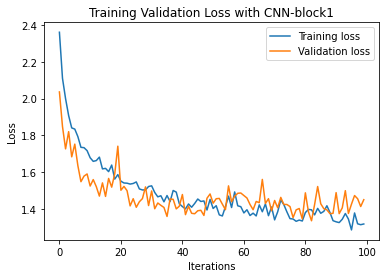

In [66]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [67]:
all_models1 = load(save_path1 + "cnn_b1_all_models.pkl")
FILE  = all_models1[-1]
m = Model_B1(make_layers1(cfg1['B1'])).to(device) 

In [68]:
m = load_best(all_models1,m)

In [69]:
train_y, train_y_hat = test(train_dataloader, m, criterion1, device, "TRAIN")

TRAIN Loss: 0.984220

TRAIN Accuracy: 64% (2921/4500)


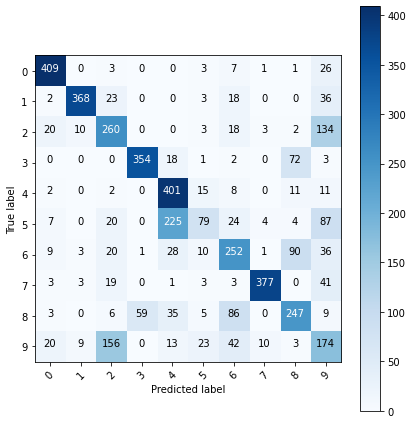

In [70]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [71]:
test_y, test_y_hat = test(test_dataloader, m, criterion1, device,"TEST")

TEST Loss: 1.333111

TEST Accuracy: 53% (269/500)


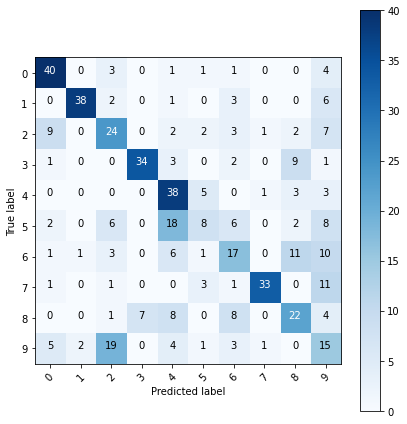

In [72]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block12

### model 

In [73]:
cfg2 = {
    'B12': [16,16,'M', 32, 32, 32,'M'],
}

In [74]:
def make_layers2(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1,padding=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [75]:
class Model_B12(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B12, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            # nn.Linear(3200, 512),
            # nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [76]:
# m = Model_B12(make_layers2(cfg2['B12']))
# for i,l in train_dataloader:
#   o = m(i)

In [77]:
model2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 
learning_rate = 0.01
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
print(model2)

Model_B12(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace=

### Train 

In [78]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block12/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block12/'

In [79]:
save_path2 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block12/"

In [80]:
m, train_losses, val_losses,m_all_models = train(save_path2,100,train_dataloader,model2,test_dataloader,optimizer2,criterion2,"cnn_b12")

Epoch: 1 	Training Loss: 2.171751 	Validation Loss: 1.995741 Test Accuracy: 0.282
Saving model..1
Epoch: 2 	Training Loss: 1.990542 	Validation Loss: 1.915036 Test Accuracy: 0.282
Saving model..2
Epoch: 3 	Training Loss: 1.959082 	Validation Loss: 1.923767 Test Accuracy: 0.276
Epoch: 4 	Training Loss: 1.886835 	Validation Loss: 1.855988 Test Accuracy: 0.325
Saving model..3
Epoch: 5 	Training Loss: 1.851520 	Validation Loss: 1.842473 Test Accuracy: 0.346
Saving model..4
Epoch: 6 	Training Loss: 1.854076 	Validation Loss: 1.682862 Test Accuracy: 0.365
Saving model..5
Epoch: 7 	Training Loss: 1.730735 	Validation Loss: 1.746108 Test Accuracy: 0.386
Epoch: 8 	Training Loss: 1.720375 	Validation Loss: 1.681886 Test Accuracy: 0.387
Saving model..6
Epoch: 9 	Training Loss: 1.685415 	Validation Loss: 1.566596 Test Accuracy: 0.466
Saving model..7
Epoch: 10 	Training Loss: 1.636025 	Validation Loss: 1.566697 Test Accuracy: 0.451
Epoch: 11 	Training Loss: 1.620809 	Validation Loss: 1.548567 Test 

### Test and Plots 

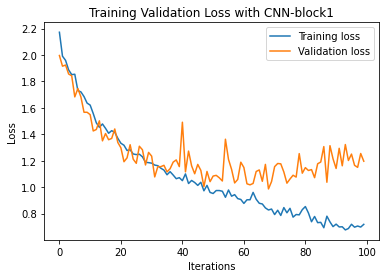

In [81]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [82]:
all_models2 = load(save_path2 + "cnn_b12_all_models.pkl")
FILE  = all_models2[-1]
m2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 

In [83]:
m2 = load_best(all_models2,m2)

In [84]:
train_y, train_y_hat = test(train_dataloader, m2, criterion2, device, "TRAIN")

TRAIN Loss: 0.573239

TRAIN Accuracy: 80% (3632/4500)


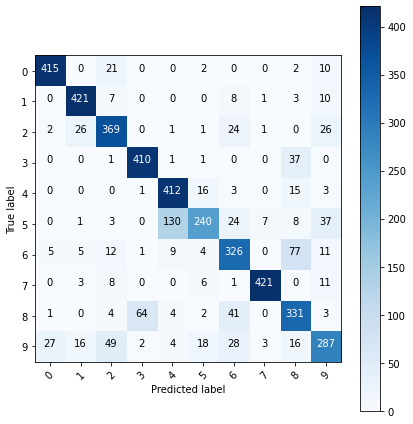

In [85]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [86]:
test_y, test_y_hat = test(test_dataloader, m2, criterion2, device,"TEST")

TEST Loss: 0.980006

TEST Accuracy: 67% (339/500)


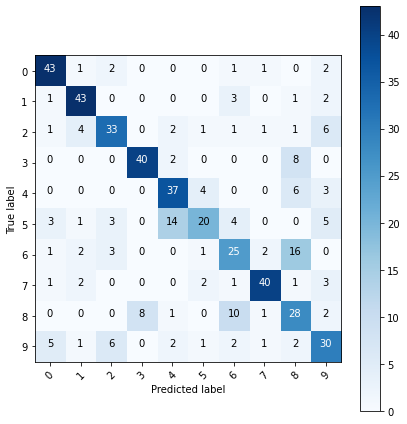

In [87]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block-123

### model 

In [88]:
cfg3 = {
    'B123': [16,16,'M',32,32,32,'M',64,'M'],
}

In [89]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [90]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1024, 512),
            # nn.ReLU(True),
            # nn.Linear(512, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 64),
            # nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        return x

In [91]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [92]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.01
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace

### train 

In [93]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block123/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block123/'

In [94]:
save_path3 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.5)/cnn_block123/"

In [95]:
m, train_losses, val_losses,m_all_models = train(save_path3,100,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"cnn_b123")

Epoch: 1 	Training Loss: 1.827655 	Validation Loss: 1.751493 Test Accuracy: 0.368
Saving model..1
Epoch: 2 	Training Loss: 1.570219 	Validation Loss: 2.207396 Test Accuracy: 0.321
Epoch: 3 	Training Loss: 1.429175 	Validation Loss: 1.518326 Test Accuracy: 0.424
Saving model..2
Epoch: 4 	Training Loss: 1.356088 	Validation Loss: 1.578036 Test Accuracy: 0.433
Epoch: 5 	Training Loss: 1.250889 	Validation Loss: 1.319470 Test Accuracy: 0.540
Saving model..3
Epoch: 6 	Training Loss: 1.154453 	Validation Loss: 1.094612 Test Accuracy: 0.604
Saving model..4
Epoch: 7 	Training Loss: 1.078889 	Validation Loss: 1.964035 Test Accuracy: 0.414
Epoch: 8 	Training Loss: 1.034973 	Validation Loss: 1.329203 Test Accuracy: 0.550
Epoch: 9 	Training Loss: 0.990524 	Validation Loss: 1.270689 Test Accuracy: 0.543
Epoch: 10 	Training Loss: 0.950024 	Validation Loss: 1.057665 Test Accuracy: 0.644
Saving model..5
Epoch: 11 	Training Loss: 0.884161 	Validation Loss: 1.147223 Test Accuracy: 0.609
Epoch: 12 	Train

### Tests and Plots 

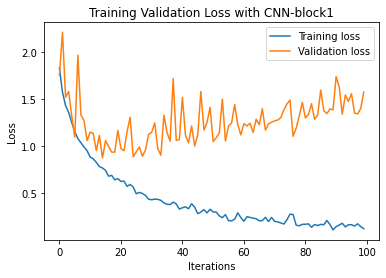

In [96]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [97]:
all_models3 = load(save_path3 + "cnn_b123_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [98]:
m3 = load_best(all_models3,m3)

In [99]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.660881

TRAIN Accuracy: 76% (3454/4500)


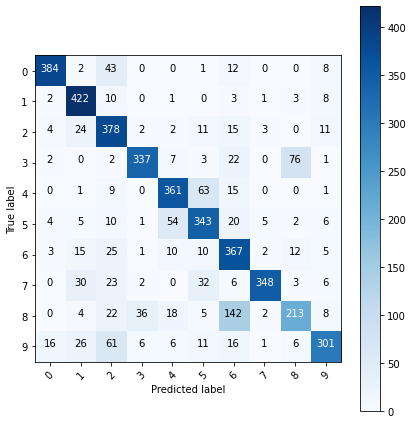

In [100]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [101]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.876783

TEST Accuracy: 69% (348/500)


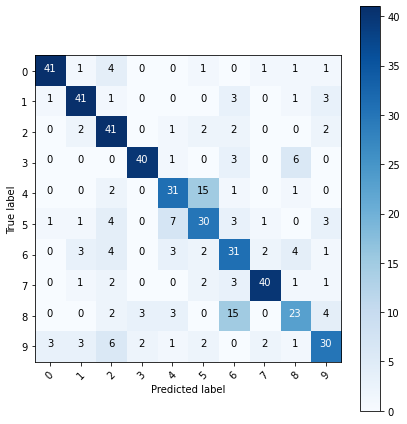

In [102]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))